# WT vs OE

In [1]:
library(sleuth)
library(splines)
library(scales)

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3


In [4]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [5]:
d=subset(d,! sample %in% exclude )

In [6]:
table(d$GT,d$Time)

          
           3 5 9 12 14
  deltaDEK 3 2 3  3  3
  LG3      3 2 3  3  3
  Loop     3 2 3  3  3
  OE       2 2 3  3  3
  WT       3 2 3  3  3

In [7]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  69 

In [8]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [9]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=paste(m$GENEID,m$class,sep=".")
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [10]:
D=droplevels(subset(d, GT %in% c("WT","OE")))
head(D)
table(D$GT,D$Time)

,sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,path
1,1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,../kallisto/kallisto/1-W3/abundance.h5
2,2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,../kallisto/kallisto/2-W3-2/abundance.h5
3,3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,../kallisto/kallisto/3-W3-3/abundance.h5
13,13-1-3-2,13.1.3.2,5,OE,3,elongated,normal,absent,absent,absent,enlarged,absent,absent,2,3d_b2,../kallisto/kallisto/13-1-3-2/abundance.h5
14,14-1-3-3,14.1.3.3,5,OE,3,elongated,normal,absent,absent,absent,enlarged,absent,absent,3,3d_b3,../kallisto/kallisto/14-1-3-3/abundance.h5
15,15-W5,15.W5,6,WT,5,normal,normal,absent,absent,absent,normal,absent,absent,1,5d_b1,../kallisto/kallisto/15-W5/abundance.h5


    
     3 5 9 12 14
  OE 2 2 3  3  3
  WT 3 2 3  3  3

In [11]:
so.D=sleuth_prep(D, target_mapping = m,aggregation_column = 'gene', extra_bootstrap_summary = TRUE)

reading in kallisto results
dropping unused factor levels
...........................
normalizing est_counts
45014 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21634 genes passed the filter
Warning message in sleuth_prep(D, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



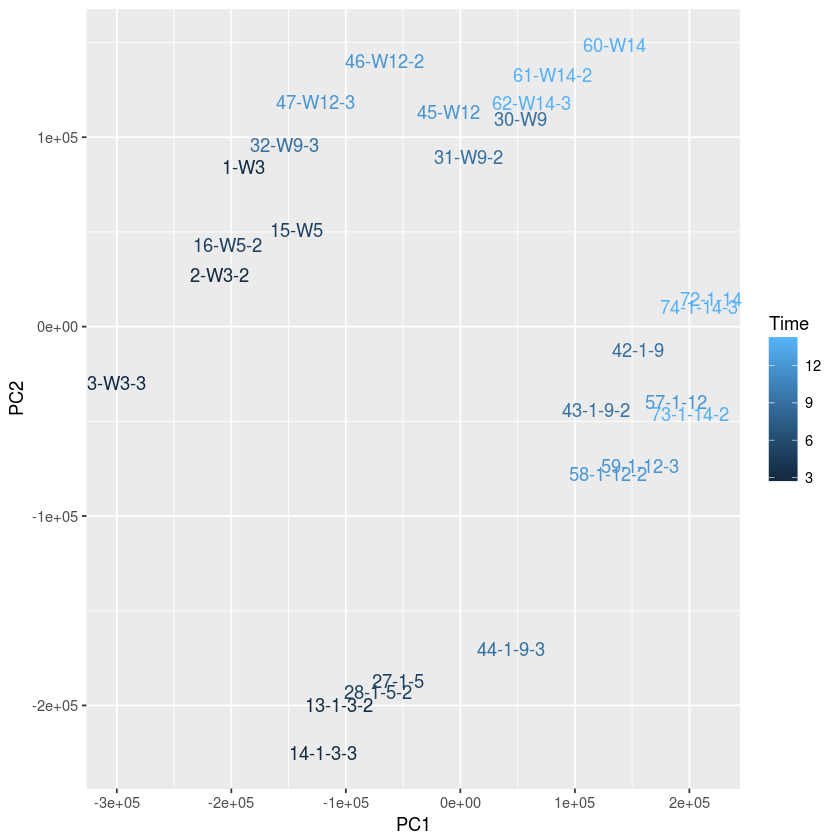

In [12]:
plot_pca(so.D, color_by = 'Time',text_labels = TRUE,units='scaled_reads_per_base')

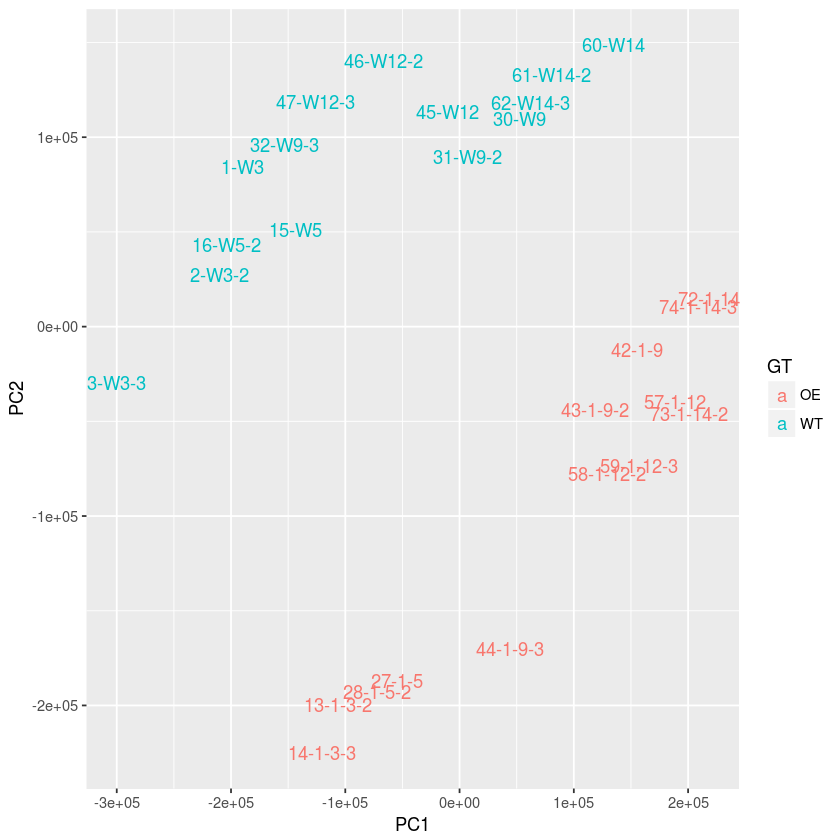

In [13]:
plot_pca(so.D, color_by = 'GT',text_labels = TRUE,units='scaled_reads_per_base')

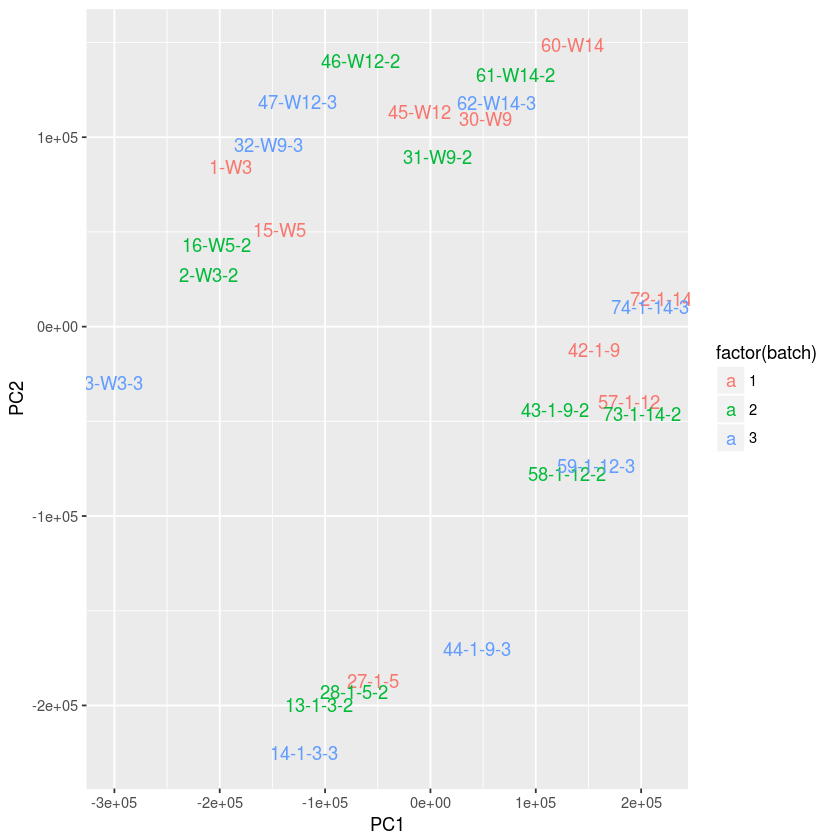

In [14]:
plot_pca(so.D, color_by = 'factor(batch)',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

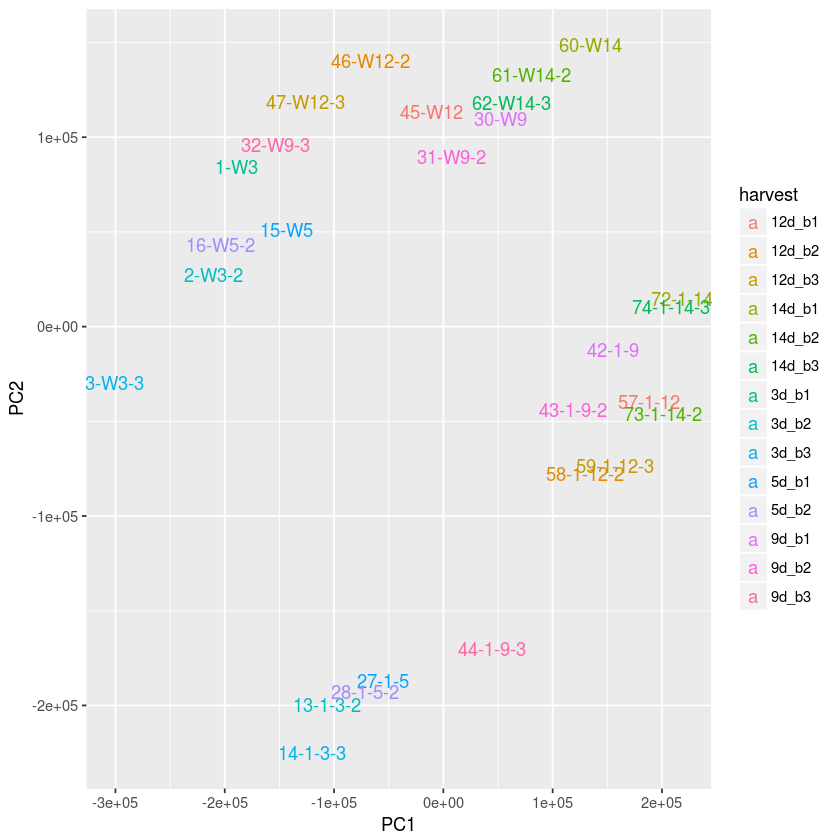

In [15]:
plot_pca(so.D, color_by = 'harvest',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

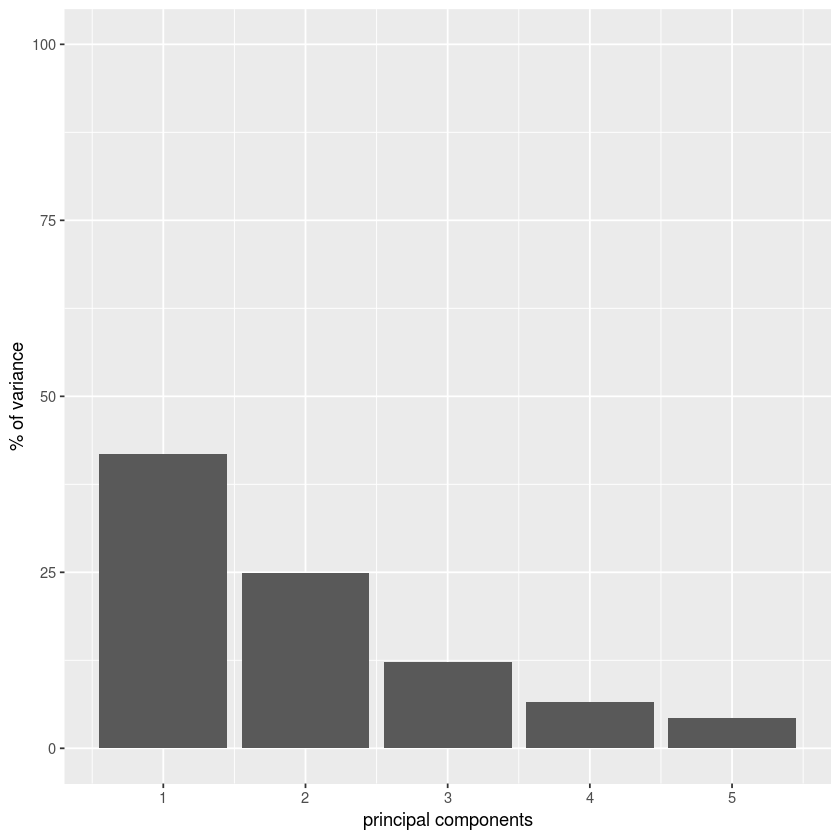

In [16]:
plot_pc_variance(so.D,units='scaled_reads_per_base')

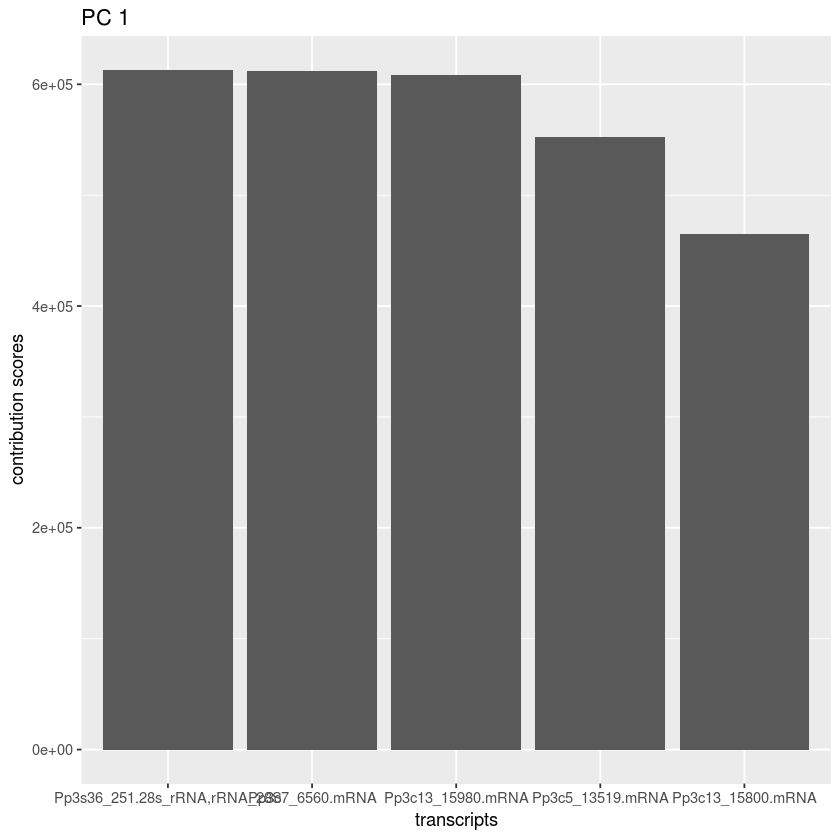

In [17]:
plot_loadings(so.D, pc_input = 1,units='scaled_reads_per_base')

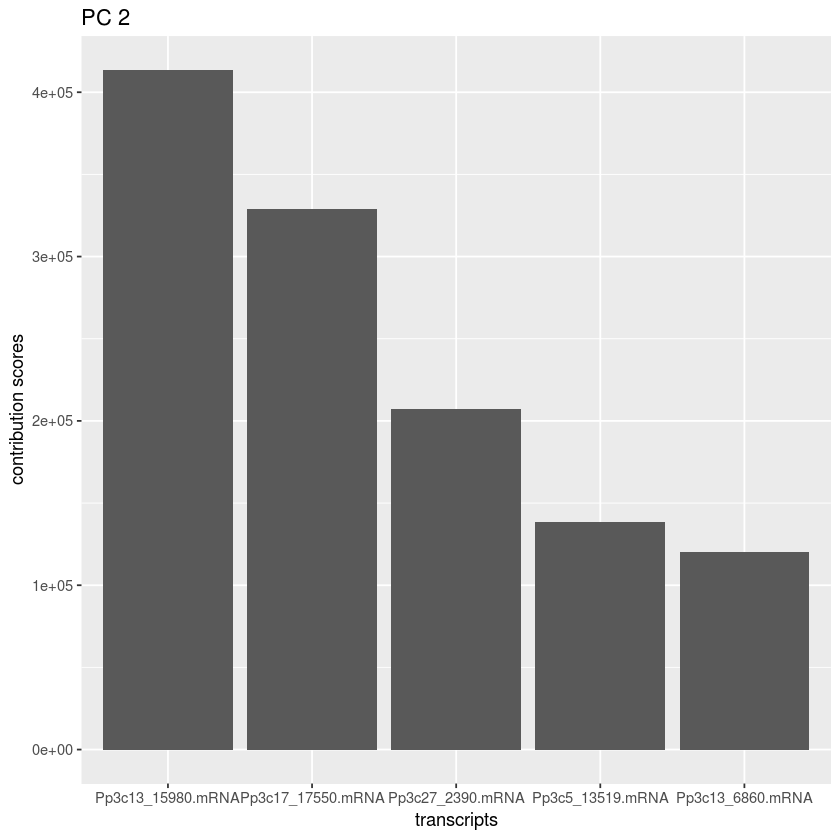

In [18]:
plot_loadings(so.D, pc_input = 2,units='scaled_reads_per_base')

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

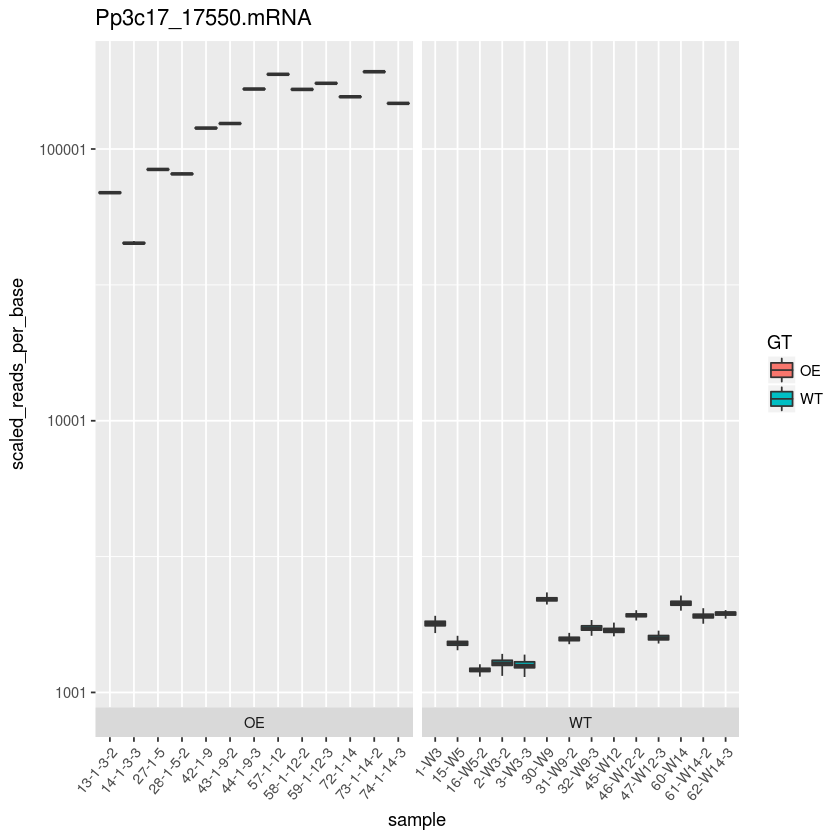

In [19]:
plot_bootstrap(so.D, 'Pp3c17_17550.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

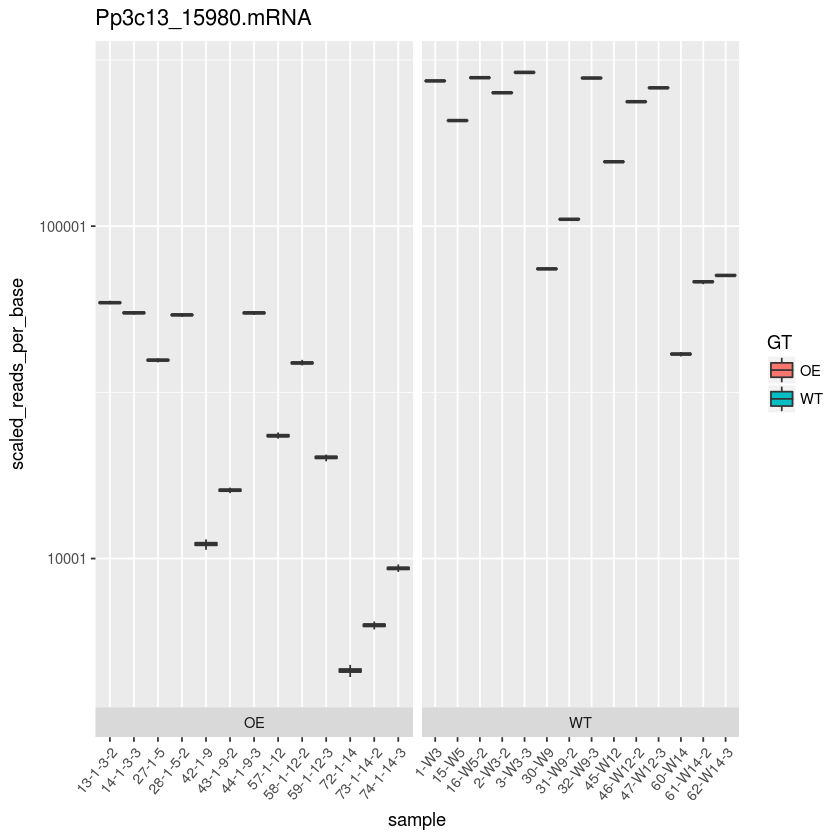

In [20]:
plot_bootstrap(so.D, 'Pp3c13_15980.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [21]:
D$GT=relevel(factor(D$GT),"WT")

In [22]:
full_design <- model.matrix(formula(~ GT + ns(Time, df = 4)),data=D)
reduced_design <- model.matrix(formula(~ ns(Time, df = 4)),data=D)

In [23]:
full_design2 <- model.matrix(formula(~ GT + factor(batch) + ns(Time, df = 4)),data=D)
reduced_design2 <- model.matrix(formula(~ factor(batch) + ns(Time, df = 4)),data=D)

In [24]:
full_design2

,(Intercept),GTOE,factor(batch)2,factor(batch)3,"ns(Time, df = 4)1","ns(Time, df = 4)2","ns(Time, df = 4)3","ns(Time, df = 4)4"
1,1,0,0,0,0.00000000,0.0000000,0.0000000,0.00000000
2,1,0,1,0,0.00000000,0.0000000,0.0000000,0.00000000
3,1,0,0,1,0.00000000,0.0000000,0.0000000,0.00000000
13,1,1,1,0,0.00000000,0.0000000,0.0000000,0.00000000
14,1,1,0,1,0.00000000,0.0000000,0.0000000,0.00000000
15,1,0,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
16,1,0,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261
27,1,1,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
28,1,1,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261
30,1,0,0,0,0.60317460,0.2095594,0.1554311,-0.11102218


In [25]:
so.D= sleuth_fit(so.D,reduced_design2,fit_name="reduced2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [26]:
so.D= sleuth_fit(so.D, full_design2, fit_name = "full2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [27]:
so.D = sleuth_lrt(so.D, "reduced2", "full2")

In [28]:
models(so.D)

[  reduced2  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,  0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,  0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 0, 0, 0, 0.0740740740740741, 0.0740740740740741, 0.0740740740740741,  0.0740740740740741, 0.603174603174603, 0.603174603174603, 0.603174603174603,  0.603174603174603, 0.603174603174603, 0.603174603174603, 0.0888888888888889,  0.0888888888888889, 0.0888888888888889, 0.0888888888888889, 0.0888888888888889,  0.0888888888888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.130189045660703,  -0.130189045660703, -0.130189045660703, -0.130189045660703, 0.209559381722464,  0.209559381722464, 0.209559381722464, 0.209559381722464, 0.209559381722464,  0.209559381722464, 0.587464387464387, 0.587464387464387, 0.587464387464387,  0.587464387464387, 0.587464387464387, 0.587464387464387, -0.128205128205128,  -0.12820512820512

In [29]:
so.D = sleuth_wt(so.D, 'GTOE', which_model = "full2")

Warning message:
“Removed 11 rows containing missing values (geom_point).”

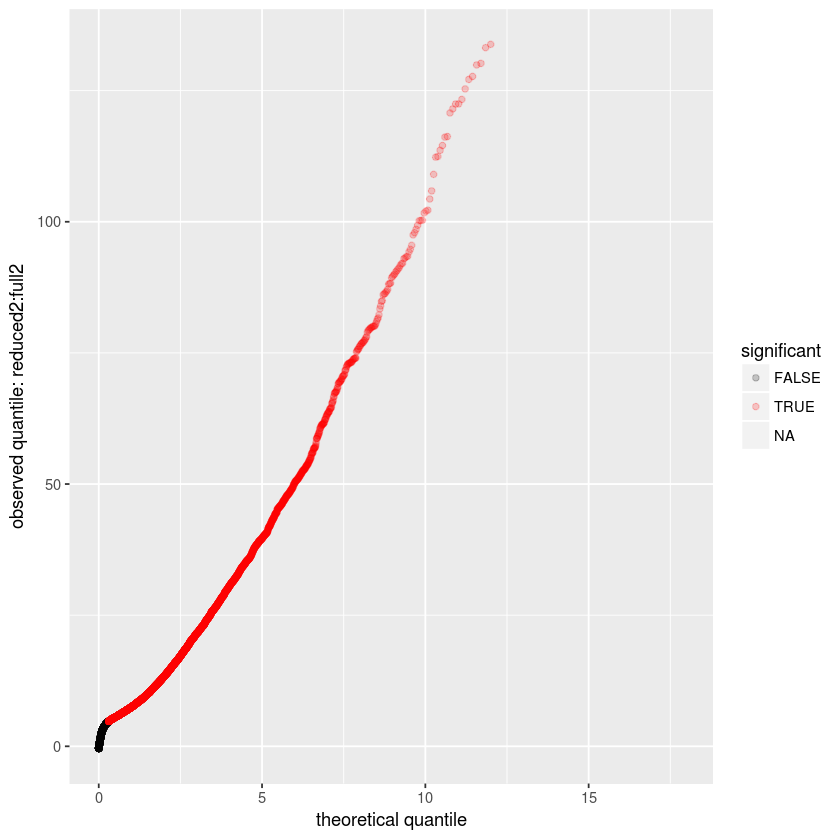

In [30]:
plot_qq(so.D, test = 'reduced2:full2', test_type = 'lrt', sig_level = 0.05)

Warning message:
“Removed 10 rows containing missing values (geom_path).”

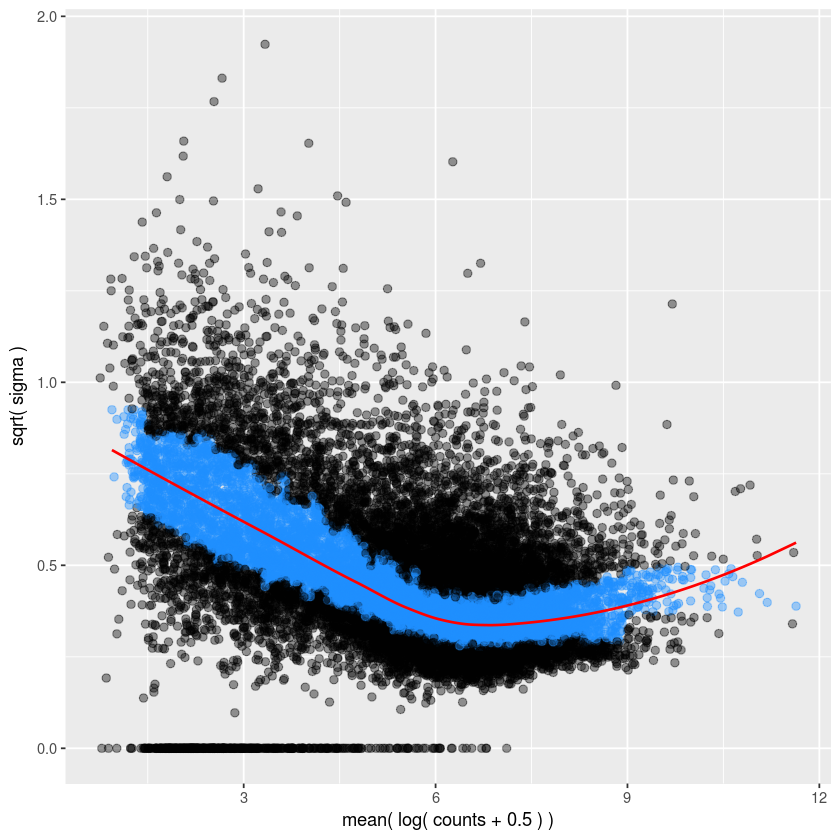

In [31]:
plot_mean_var(so.D,which_model="full2")

In [32]:
tt=sleuth_results(so.D,'GTOE','wt',which_model="full2" ,show_all = FALSE,rename_cols=FALSE)
tt.sig= dplyr::filter(tt, qval < 0.05)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 5741


FALSE  TRUE 
 3094  2647 

In [33]:
lrt_results= sleuth_results(so.D, 'reduced2:full2', test_type = 'lrt',show_all=TRUE)

In [34]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
10873 10750 

,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,sigma_sq_pmax,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
21415,Pp3s320_10.ncRNA,73.15500,1.198576e-17,2.399705e-15,325.1494,15.554320,0.703149328,2.874185,12.604898,15.554320,⋯,8.849644e-61,2.517957e-58,6.747895,0.4102875,2.874185,12.604898,0.703149328,0.42000952,0.1582728,0.4200095
13404,Pp3c24_2170.mRNA,120.75148,4.331291e-28,7.804625e-25,268.7549,13.435918,0.001825746,2.354095,10.538320,13.435918,⋯,2.653385e-271,7.172100e-268,6.318964,0.1795570,2.354095,10.538320,0.001825746,0.12140256,0.2132885,0.2132885
17670,Pp3c5_28230.mRNA,121.51824,2.942832e-28,5.784805e-25,222.6140,11.127815,0.002886804,2.086505,8.657624,11.127815,⋯,1.350352e-195,1.536842e-192,5.772998,0.1934937,2.086505,8.657624,0.002886804,0.01019570,0.2469165,0.2469165
7782,Pp3c17_9369.mRNA,69.38040,8.119141e-17,1.310151e-14,156.4655,7.709735,0.113539997,2.490211,6.169379,7.709735,⋯,1.516843e-52,3.153868e-50,4.656240,0.3052202,2.490211,6.169379,0.113539997,0.50803158,0.1976273,0.5080316
7764,Pp3c17_8860.mRNA,89.85524,2.562388e-21,1.178862e-18,124.0582,6.174242,0.028666557,1.461105,4.851326,6.174242,⋯,1.948656e-73,7.022957e-71,4.271732,0.2356548,1.461105,4.851326,0.028666557,0.09276413,0.3418582,0.3418582
5094,Pp3c14_2570.mRNA,33.57220,6.866726e-09,1.862976e-07,169.4721,6.372356,2.101247512,3.402167,7.369462,6.372356,⋯,4.654928e-12,1.369499e-10,4.263611,0.6165101,3.402167,7.369462,2.101247512,0.43472739,0.1143998,0.4347274


In [35]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [36]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"CHR1545,chr1545"
Pp3c10_13960,"CHLH1,chlh2,CHLH2,chlh1"
Pp3c10_13970,"chlh1,CHLH2,chlh2,CHLH1"
Pp3c10_14020,"raba53,RABA53"
Pp3c10_14800,"ppr_20,PPR_20"


In [37]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [38]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [39]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21623

[1] 21623

[1] 21623

[1] 21623

[1] 21623

,GENEID,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
9742,Pp3c2_27820,Pp3c2_27820.mRNA,133.8268,5.961534e-31,8.862515e-27,304.0770,15.17725,0.0265996593,2.932226,11.792892,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
3856,Pp3c13_120,Pp3c13_120.mRNA,133.1945,8.197304e-31,8.862515e-27,320.6798,16.00272,0.0312635467,3.050086,12.495566,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
7326,Pp3c17_17550,Pp3c17_17550.mRNA,130.1988,3.707194e-30,2.339794e-26,122.2113,6.11020,0.0003652192,9.485208,4.872353,⋯,true,"false,true",protein_coding_gene,false,DEK1,pdef,3.4.22.54 - Calpain-3 / Muscle-specific calcium-activated neutral protease 3 (1 of 2),NA,NA,NA
21481,Pp3s44_20,Pp3s44_20.mRNA,129.8913,4.328343e-30,2.339794e-26,272.7595,13.62697,0.0110042352,2.685268,10.657684,⋯,true,true,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
7784,Pp3c17_9430,Pp3c17_9430.mRNA,127.7082,1.300221e-29,5.622936e-26,270.7555,13.51833,0.0194442412,2.656225,10.433140,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR11439//PTHR11439:SF180 - GAG-POL-RELATED RETROTRANSPOSON // SUBFAMILY NOT NAMED (1 of 1),NA,NA,NA
16532,Pp3c4_21860,Pp3c4_21860.mRNA,127.1322,1.738035e-29,6.263588e-26,301.4739,15.07197,0.0017271184,2.771375,11.722533,⋯,true,false,protein_coding_gene,false,NA,pdef,PF14009 - Domain of unknown function (DUF4228) (DUF4228) (1 of 19),NA,NA,NA


In [40]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7326
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
test_stat,130.1988
pval.lrt,3.707194e-30
qval.lrt,2.339794e-26
rss,122.2113
sigma_sq.lrt,6.1102
tech_var,0.0003652192
mean_obs.lrt,9.485208
var_obs.lrt,4.872353


In [41]:
table(o$qval.lrt<0.05)
table(o$qval.wt<0.05)
table(o$qval.lrt<0.05,o$qval.wt<0.05)


FALSE  TRUE 
 9168 12455 


FALSE  TRUE 
15882  5741 

       
        FALSE TRUE
  FALSE  9168    0
  TRUE   6714 5741

In [42]:
head(O[,c("target_id","test_stat","b","qval.lrt","qval.wt","name","superfamily","TAP_class","defline")],n=50)

,target_id,test_stat,b,qval.lrt,qval.wt,name,superfamily,TAP_class,defline
9742,Pp3c2_27820.mRNA,133.82682,-6.7388424,8.862515e-27,0.000000e+00,NA,NA,NA,NA
3856,Pp3c13_120.mRNA,133.19453,-6.9158301,8.862515e-27,0.000000e+00,NA,NA,NA,NA
7326,Pp3c17_17550.mRNA,130.19883,4.2627846,2.339794e-26,0.000000e+00,DEK1,NA,NA,3.4.22.54 - Calpain-3 / Muscle-specific calcium-activated neutral protease 3 (1 of 2)
21481,Pp3s44_20.mRNA,129.89134,-6.3809738,2.339794e-26,0.000000e+00,NA,NA,NA,NA
7784,Pp3c17_9430.mRNA,127.70817,-6.3556988,5.622936e-26,1.093878e-292,NA,NA,NA,PTHR11439//PTHR11439:SF180 - GAG-POL-RELATED RETROTRANSPOSON // SUBFAMILY NOT NAMED (1 of 1)
16532,Pp3c4_21860.mRNA,127.13218,-6.6953791,6.263588e-26,0.000000e+00,NA,NA,NA,PF14009 - Domain of unknown function (DUF4228) (DUF4228) (1 of 19)
4428,Pp3c13_7860.mRNA,125.33455,-5.9502673,1.328227e-25,5.577176e-236,NA,NA,NA,K10743 - ribonuclease H2 subunit A (RNASEH2A) (1 of 1)
7779,Pp3c17_9310.mRNA,123.32184,-7.5834611,3.204769e-25,0.000000e+00,NA,NA,NA,PF08148 - DSHCT (NUC185) domain (DSHCT) (1 of 6)
8574,Pp3c19_14410.mRNA,122.47116,-6.2694502,3.975301e-25,9.065938e-214,NA,NA,NA,PTHR22957//PTHR22957:SF327 - TBC1 DOMAIN FAMILY MEMBER GTPASE-ACTIVATING PROTEIN // SUBFAMILY NOT NAMED (1 of 4)
21328,Pp3s128_60.mRNA,122.45160,-5.7617524,3.975301e-25,6.535183e-214,NA,NA,NA,NA


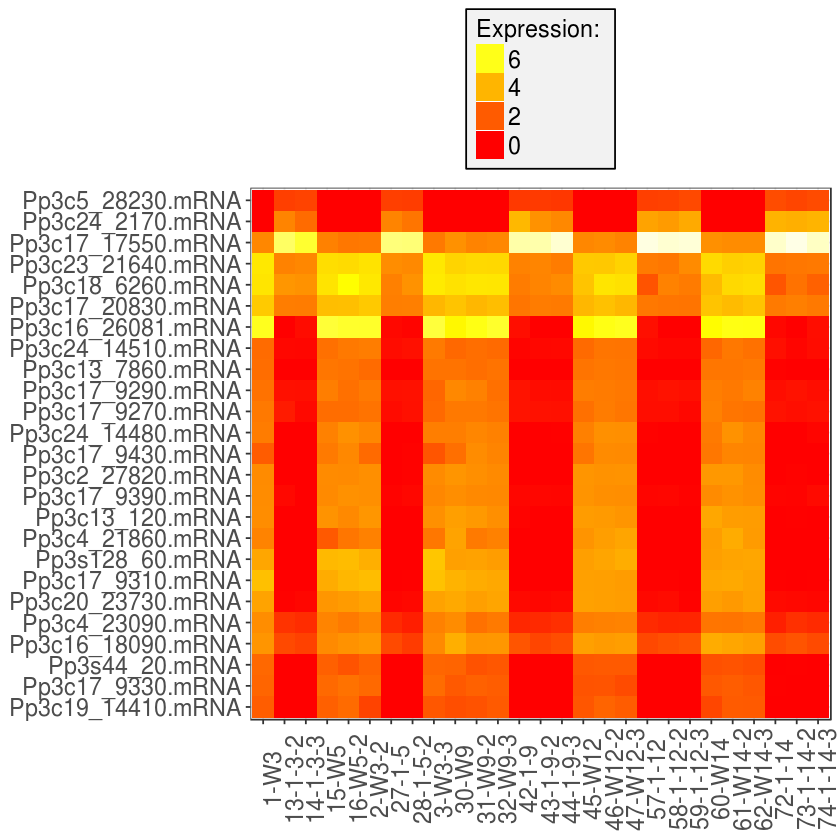

In [43]:
plot_transcript_heatmap(so.D, head(O, n = 25)$target_id)

In [44]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.1)[,c("target_id","test_stat","b","qval.lrt","qval.wt","Alias")]

,target_id,test_stat,b,qval.lrt,qval.wt,Alias
4411,Pp3c13_7201.pre_miRNA,27.481447,-0.63881267,2.901520e-06,9.030487e-08,"MI0005966,Pp3c13_7201V1.1,ppt-MIR1025,Pp3c13_7201N1.1,N1.Chr13.ncRNA.30"
9001,Pp3c19_7045.pre_miRNA,11.581965,0.77567676,3.574910e-03,1.336781e-02,"Pp3c19_7045V1.1,MIR159.4,ppt-MIR319b,MIR159,Pp3c19_7045N1.1,N1.Chr19.ncRNA.58,MI0003497"
7039,Pp3c16_9758.pre_miRNA,11.092255,-0.52368967,4.429291e-03,8.226633e-03,"MI0003501,Pp3c16_9758N1.1,ppt-MIR534a,N1.Chr16.ncRNA.50,Pp3c16_9758V1.1"
8402,Pp3c18_7951.pre_miRNA,9.430409,0.21961587,9.039587e-03,1.825621e-02,"Pp3c18_7951V1.1,Pp3c18_7951N1.1,ppt-MIR319a,N1.Chr18.ncRNA.41,MI0003496"
12822,Pp3c23_3768.pre_miRNA,6.181279,-0.21037564,3.143102e-02,1.760498e-01,"Pp3c23_3768V1.1,ppt-MIR536b,MI0005691,Pp3c23_3768N1.1,N1.Chr23.ncRNA.15"
12124,Pp3c22_2794.pre_miRNA,5.700696,0.19712998,3.699423e-02,2.470173e-01,"MI0003499,Pp3c22_2794N1.1,MIR159.3,ppt-MIR319d,Pp3c22_2794V1.1,N1.Chr22.ncRNA.13,MIR159"
7592,Pp3c17_2572.pre_miRNA,5.453147,-0.38037353,3.995880e-02,3.187955e-01,"MI0006015,N1.Chr17.ncRNA.13,Pp3c17_2572V1.1,ppt-MIR1056,Pp3c17_2572N1.1"
20407,Pp3c8_7462.pre_miRNA,4.866632,0.02416266,4.839836e-02,9.555519e-01,"ppt-MIR1049,Pp3c8_7462V1.1,N1.Chr08.ncRNA.35,Pp3c8_7462N1.1,MI0006008"
18649,Pp3c6_4708.pre_miRNA,4.526893,0.47550314,5.506610e-02,2.327108e-01,"Pp3c6_4708N1.3,ppt-MIR1223a,Pp3c6_4708V1.1,ppt-MIR1223c,MI0004728,Pp3c6_4708N1.1,Pp3c6_4708N1.2,Pp3c6_4708V1.2,N1.Chr06.ncRNA.32,N1.Chr06.ncRNA.33,MI0005952"
16254,Pp3c4_14601.pre_miRNA,3.829883,0.36167324,7.429475e-02,1.851459e-01,"ppt-MIR1219a,Pp3c4_14601V1.1,Pp3c4_14601N1.1,Pp3c4_14601V1.2,MI0004718,MI0004719,Pp3c4_14601N1.2,ppt-MIR1219b,N1.Chr04.ncRNA.70,N1.Chr04.ncRNA.71"


In [45]:
write.table(o,gzfile("comp.WT_vs_OE/dge.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile("comp.WT_vs_OE/dge.full.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)